# RandAugmenter Demo 
 
##### Get the new sorted dataset [here](https://tumde-my.sharepoint.com/:f:/g/personal/gohdennis_tum_de/EmooVZ4vE95Iic-HIP9-P10BzX7oIOBmRhK8Q9tYzfJWRQ?e=maOqo5) [08_Aug_2022]

Annotations are stored under notebooks/preprocesing/restructured_w_original_labels.json (also in the .zip file)

Extract the zip under data/.


<hr style="height:2px;border-width:0;color:black;background-color:black">

This notebook will show the class working on a tf.data.Dataset object

In [1]:
import os, sys
from preprocessing.rand_augmenter import RandAugmenter
import json
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

2022-08-25 10:41:06.666747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 10:41:06.666788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load data from disk

The data is then split into a training and validation set.

In [2]:
image_path = Path(os.getenv('DATA'), 'sort')

train_ds = tf.keras.utils.image_dataset_from_directory(directory=image_path, validation_split=0.3, subset='training', seed=0, image_size=(224, 224))
val_ds = tf.keras.utils.image_dataset_from_directory(directory=image_path, validation_split=0.3, subset='validation', seed=0, image_size=(224, 224))

# get current working directory

with Path(os.getenv('DATA'),'restructured_w_original_labels.json').open() as f:
    data = json.load(f)


Found 897 files belonging to 4 classes.
Using 628 files for training.
Found 897 files belonging to 4 classes.
Using 269 files for validation.


2022-08-25 10:41:10.352342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 10:41:10.352384: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 10:41:10.352401: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dens): /proc/driver/nvidia/version does not exist
2022-08-25 10:41:10.352755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset overview

In [3]:
categories = data['categories']
images = data['images']
annotations = data['annotations']

print(f"#categories: {len(categories)}")
print(f"#images: {len(images)}")
print(f"#annotations: {len(annotations)}")
print(f'Classes: {[x["name"] for x in categories]}')

#categories: 4
#images: 9585
#annotations: 897
Classes: ['dent', 'other', 'rim', 'scratch']


##  Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## Plot some sample images

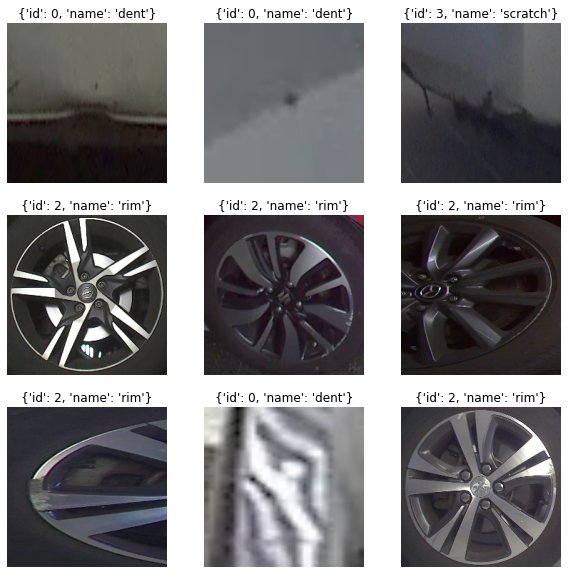

In [5]:
plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(categories[label[i]])
        plt.axis("off")

## Define parameters for RandAugmenter

In [6]:
op_list = [
    #'AutoContrast', # problematic for 4D Tensors,but runs fine for single images [224 224 3]
    #'Equalize', # problematic for 4D Tensors,but runs fine for single images [224 224 3]
    'Invert',
    'Rotate',
    'Posterize',
    'Solarize',
    'SolarizeAdd',
    'Color',
    'Contrast',
    'Brightness',
    #'Sharpness',  # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset [32 224 224 3]
    #'ShearX', # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset[32 224 224 3]
    #'ShearY', # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset[32 224 224 3]
    'TranslateX',
    'TranslateY',
    #'Cutout' # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset[32 224 224 3]
]
N = 2
M = 9


## Let's do the augmentation

In [7]:
Augmenter = RandAugmenter(N, M, op_list)
Augmenter.summary()
target_size = 3000 
aug_ds = Augmenter.transform(train_ds, target_size)

['Invert', 'Rotate', 'Posterize', 'Solarize', 'SolarizeAdd', 'Color', 'Contrast', 'Brightness', 'TranslateX', 'TranslateY']
2 layers with magnitude 9, with a total of 10 operations.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Plotting the augmentation results

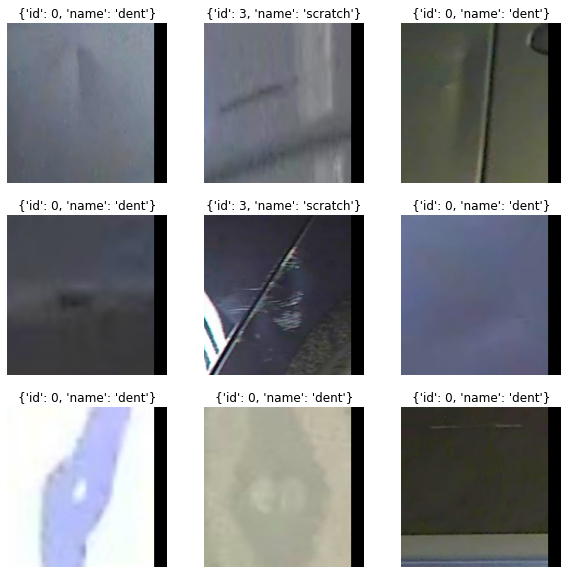

In [8]:
plt.figure(figsize=(10, 10))
for image, label in aug_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(categories[label[i]])
        plt.axis("off")

# Problems
### This section will show some problems with the current implementation of the operations

In [9]:
# Self test just generates 3D/4D tensors and runs it through all the operations in operations.py
# arr_3d = tf.random.uniform(shape=[224, 224, 3]) A 3D tensor like this
# arr_4d = tf.random.uniform(shape=[32, 224, 224, 3]) or a 4D tensor like this
Augmenter.self_test()

Set of failed 3D operations : []
Set of failed 4D operations : ['Sharpness', 'ShearX', 'ShearY', 'Cutout']


The ones under failed 4D operations shouldn't be used when using the method Augmenter.transform()!

#### AutoContrast and Equalize not working properly on batches yet (4D image Tensors)

##### Leave them out when using RandAugmenter.transform()

Let's test them to see what happens when using it for 4D tensors 

In [10]:
op_list_broken = [
    'AutoContrast',  # problematic for 4D Tensors,but runs fine for single images [224 224 3]
    'Equalize'  # problematic for 4D Tensors,but runs fine for single images [224 224 3]
]
test_aug = RandAugmenter(2,9,op_list_broken)
test_aug.set_operations(op_list_broken)
test_aug.summary()

['AutoContrast', 'Equalize']
2 layers with magnitude 9, with a total of 2 operations.


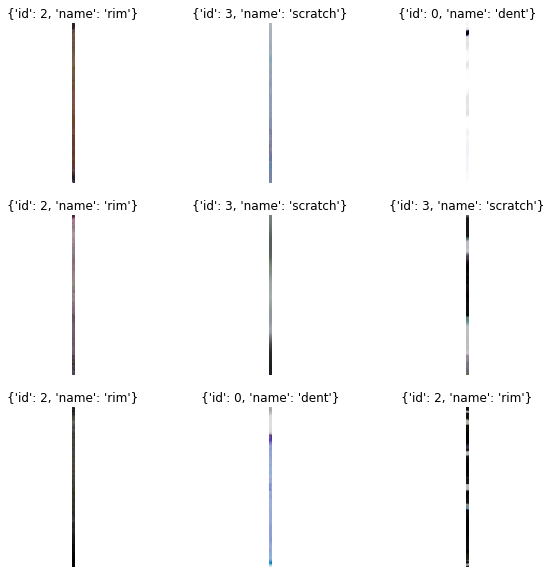

In [11]:
aug_ds_2 = test_aug.transform(train_ds, target_size)

plt.figure(figsize=(10, 10))
for image, label in aug_ds_2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(categories[label[i]])
        plt.axis("off")

They run but the image would be false data.

## Let's try out AutoContrast and Equalize on single images

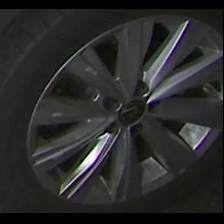

In [12]:
p = Path(os.getenv('DATA'), 'sort','rim','504014.png')

im = tf.keras.preprocessing.image.load_img(p)
arr = tf.keras.utils.img_to_array(im)
im = tf.image.resize_with_pad(arr, 224, 224)
tf.keras.preprocessing.image.array_to_img(im)

In [13]:
test_aug.set_verbose(True)

### They work fine with 3D image Tensors

i.e. you can use all the transformations when wrapping RandAugmenter as a tf.keras.layers.Layer object if the inputs are 3D image tensors

Equalize
AutoContrast


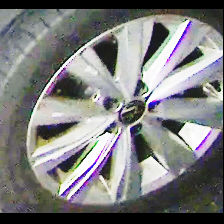

In [14]:
arr = tf.keras.utils.img_to_array(im)
new_im = test_aug.randaugment_transform(arr)
tf.keras.preprocessing.image.array_to_img(new_im)